# Address Matching with Apache Spark

## Iniciar Spark

In [1]:
from pyspark.sql.session import SparkSession

spark = SparkSession.builder \
    .appName("Adress Matching") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "20g") \
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate()
    #.config("spark.local.dir", "/spark-tmp") \

24/04/27 08:42:30 WARN Utils: Your hostname, ubuntu resolves to a loopback address: 127.0.1.1; using 10.6.130.30 instead (on interface ens3)
24/04/27 08:42:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/27 08:42:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
conf = spark.sparkContext.getConf()
for (key, value) in conf.getAll():
  print(f"{key}: {value}")

spark.app.name: Adress Matching
spark.executor.memory: 2g
spark.driver.extraJavaOptions: -Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false
spark.app.id: local-1714207352458
spark.executor.id: dr

## Leer fichero

El dataset continene exactamente 24 columnas las cuales, el ***, almacena información relevante el trabajo que realizan. En cambio, en este proyecto, se utilizarán las siguientes columnas pues contienen la información más relevante:
- **uuid_idt**: contiene un identificador alfanumérico único para cada dirección.
- **tvia**: contiene el tipo de vía, es decir, si es una calle, avenida, carretera, etc.
- **nvia**: contiene el nombre de la vía.
- **numer**: contiene el número de la vía.
- **codmun**: está compuesto por un código numérico que identifica a un municipio, es decir, el código postal.
- **nommun**: contiene el nombre del municipio.
- **direccion**: contiene la dirección completa."

In [3]:
# Leer el archivo CSV y cargarlo en un DataFrame
file =  "../data/raw_data/TFM_Direcciones.tab"
first_df = spark.read.option("delimiter", "\t").option("encoding", "windows-1252").csv(file, header=True, inferSchema=True)

# Seleccionar solo las columnas deseadas
selected_columns = [
  "uuid_idt",
  "latitud",
  "longitud",
  "tvia",
  "nvia",
  "numer",
  "codmun",
  "nommun",
  "direccion",
]
first_df = first_df.select(selected_columns)

# Mostrar el DataFrame
first_df.show()
first_df.schema
print(first_df.count())
size_df = first_df.count()

+--------------------+---------+----------+------------+--------------------+-----+------+------+--------------------+
|            uuid_idt|  latitud|  longitud|        tvia|                nvia|numer|codmun|nommun|           direccion|
+--------------------+---------+----------+------------+--------------------+-----+------+------+--------------------+
|027C0FF8-B17B-11E...| 28.10351| -15.71037|       CALLE|        FUENTE SANTA|    5| 35001|Agaete|CALLE FUENTE SANT...|
|028F2302-B17B-11E...| 28.10011| -15.69867|       CALLE|       CRUZ CHIQUITA|    2| 35001|Agaete|CALLE CRUZ CHIQUI...|
|02918516-B17B-11E...| 28.10106| -15.70524|URBANIZACION|RESIDENCIAL PALMERAL|    9| 35001|Agaete|URBANIZACION RESI...|
|03A306C0-7525-11E...| 28.10225| -15.69982|       CALLE|SEÑORITA MARIA MA...|    2| 35001|Agaete|CALLE SEÑORITA MA...|
|03A306C0-7525-11E...| 28.10225| -15.69982|       CALLE|SRTA M MANRIQUE LARA|    2| 35001|Agaete|CALLE SRTA M MANR...|
|03A306C0-7525-11E...| 28.10225| -15.69982|     

1784217


In [4]:
from pyspark.sql.functions import upper

file =  "../data/raw_data/data-09022024.csv"
second_df = spark.read.option('header', True).csv(file)

selected_columns = [
  "uuid_idt",
  "latitud",
  "longitud",
  "codmun",
  "nommun",
  "direccion"
]

second_df = second_df.select(selected_columns)
second_df = second_df.select(
  upper('uuid_idt').alias('uuid_idt'), 
  'latitud',
  'longitud',
  'codmun', 
  upper('nommun').alias('nommun'), 
  'direccion'
  )
second_df.show()
first_df.schema
print(second_df.count())
size_df += second_df.count()

+--------------------+---------+----------+------+--------------------+--------------------+
|            uuid_idt|  latitud|  longitud|codmun|              nommun|           direccion|
+--------------------+---------+----------+------+--------------------+--------------------+
|C0CF3B94-0AD1-11E...| 28.09315| -15.44562| 35016|LAS PALMAS DE GRA...|IGUAZU 42 0 LAS P...|
|73B57C1B-3251-11E...|28.100397|-15.446634| 35016|LAS PALMAS DE GRA...|PARQUE CENTRAL BL...|
|C70E3EC6-3EDA-11E...| 28.12209| -15.43886| 35016|LAS PALMAS DE GRA...|CONCEJAL GARCIA F...|
|687BA81E-3251-11E...|28.128481|-15.508722| 35006|              ARUCAS|PEDRO MORALES DEN...|
|74921989-3251-11E...|27.765042|-15.586671| 35019|SAN BARTOLOMÉ DE ...|ISLA LOBOS 19 0 S...|
|6C0D19FF-3251-11E...|28.112275|-15.419253| 35016|LAS PALMAS DE GRA...|CALLE LEON Y CAST...|
|6360FDCD-3251-11E...|28.116229|-15.443305| 35016|LAS PALMAS DE GRA...|VIGEN PILAR 45 4 ...|
|758B3855-3251-11E...|28.091282|-15.460183| 35016|LAS PALMAS DE GRA...

In [5]:
print(size_df)

2414514


In [6]:
from pyspark.sql.functions import count

def uuid_frecuency(dataframe):
    values_under_10 = dataframe.groupBy(dataframe.uuid_idt).count() \
        .filter('count < 9') \
        .groupBy('count') \
        .agg(count('*') \
        .alias('Frecuencia')) \
        .orderBy('count')
    values_under_10 = values_under_10.withColumnRenamed('count', 'Número de direcciones asociadas')

    values_over_10 = dataframe.groupBy(dataframe.uuid_idt).count() \
        .filter('count > 9')
    values_over_10 = spark.createDataFrame(
        [['10 o más', values_over_10.count()]],
        ['Número de direcciones asociadas', 'Frecuencia']
        )

    values = values_under_10.union(values_over_10)
    values.show()

uuid_frecuency(first_df)
uuid_frecuency(second_df)

+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    267275|
|                              2|    115343|
|                              3|     60757|
|                              4|     35631|
|                              5|     22207|
|                              6|     14810|
|                              7|     10142|
|                              8|      7411|
|                       10 o más|     25539|
+-------------------------------+----------+



+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    250632|
|                              2|     51645|
|                              3|     19692|
|                              4|      9055|
|                              5|      4702|
|                              6|      2876|
|                              7|      1772|
|                              8|      1161|
|                       10 o más|      4083|
+-------------------------------+----------+



## Unión de los dataframes

In [7]:
# Seleccionar los UUID únicos del primer DataFrame
unique_uuid_first_df = first_df.select("uuid_idt").distinct()

# Seleccionar los UUID únicos del segundo DataFrame
unique_uuid_second_df = second_df.select("uuid_idt").distinct()

# Encontrar los UUID comunes
uuid_comunes = unique_uuid_first_df.join(unique_uuid_second_df, "uuid_idt", "inner")
# Da el mismo resultado: uuid_primero.intersect(uuid_segundo)

# Juntar los UUID comunes con el primer DataFrame
adresses_df = first_df.unionByName(second_df.join(uuid_comunes, "uuid_idt", "inner"), allowMissingColumns=True)

# Mostrar el resultado
adresses_df.show()
print("Tamaño del dataframe ampliado: ", adresses_df.count())

# Si se quiere comprobar que la operación es correcta
print("Número de uuid_idt nuevos del segundo dataframe: ", unique_uuid_second_df.subtract(uuid_comunes).count())

+--------------------+---------+----------+------------+--------------------+-----+------+------+--------------------+
|            uuid_idt|  latitud|  longitud|        tvia|                nvia|numer|codmun|nommun|           direccion|
+--------------------+---------+----------+------------+--------------------+-----+------+------+--------------------+
|027C0FF8-B17B-11E...| 28.10351| -15.71037|       CALLE|        FUENTE SANTA|    5| 35001|Agaete|CALLE FUENTE SANT...|
|028F2302-B17B-11E...| 28.10011| -15.69867|       CALLE|       CRUZ CHIQUITA|    2| 35001|Agaete|CALLE CRUZ CHIQUI...|
|02918516-B17B-11E...| 28.10106| -15.70524|URBANIZACION|RESIDENCIAL PALMERAL|    9| 35001|Agaete|URBANIZACION RESI...|
|03A306C0-7525-11E...| 28.10225| -15.69982|       CALLE|SEÑORITA MARIA MA...|    2| 35001|Agaete|CALLE SEÑORITA MA...|
|03A306C0-7525-11E...| 28.10225| -15.69982|       CALLE|SRTA M MANRIQUE LARA|    2| 35001|Agaete|CALLE SRTA M MANR...|
|03A306C0-7525-11E...| 28.10225| -15.69982|     

Tamaño del dataframe ampliado:  2234214


Número de uuid_idt nuevos del segundo dataframe:  148073


In [8]:
uuid_frecuency(adresses_df)

+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    211768|
|                              2|    119917|
|                              3|     70050|
|                              4|     44000|
|                              5|     28925|
|                              6|     19650|
|                              7|     14050|
|                              8|     10331|
|                       10 o más|     38060|
+-------------------------------+----------+



## Partición del dataset

In [9]:
adresses_df = adresses_df.repartition(32)

## Limpieza del dataset

Tras visualizar el dataset, se observa que hay columnas que tienen valores desconocidos, representados con '_U', y camos vacíos.

In [10]:
print(f"Initial dataset size: {adresses_df.count()}")

Initial dataset size: 2234214


### Valores nulos

In [11]:
from pyspark.sql.functions import isnan, when, count, col

adresses_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in adresses_df.columns]).show()

+--------+-------+--------+------+------+------+------+------+---------+
|uuid_idt|latitud|longitud|  tvia|  nvia| numer|codmun|nommun|direccion|
+--------+-------+--------+------+------+------+------+------+---------+
|       0|      0|       0|580357|460216|449997|     0|     0|        0|
+--------+-------+--------+------+------+------+------+------+---------+



In [12]:
adresses_df = adresses_df.na.fill('_U')

adresses_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in adresses_df.columns]).show()

+--------+-------+--------+----+----+------+------+------+---------+
|uuid_idt|latitud|longitud|tvia|nvia| numer|codmun|nommun|direccion|
+--------+-------+--------+----+----+------+------+------+---------+
|       0|      0|       0|   0|   0|449997|     0|     0|        0|
+--------+-------+--------+----+----+------+------+------+---------+



### Extracción del prefijo para eleminar valores '_U'

Tras analizar el dataset, se observa que para una dirección, el tipo de vía (tvia) puede aparecer vacío, en cambio, en la columna 'direccion' aparece este valor. Por lo que se procederá a extraer el prefijo de la columna 'direccion' para rellenar los valores vacíos de la columna 'tvia' evitando así la perdida de información.

In [13]:
print(f"Unknown tvia before prefix extraction: {adresses_df.filter(adresses_df.tvia == '_U').count()}")

Unknown tvia before prefix extraction: 580357


In [14]:
tvia_types = adresses_df.select("tvia").distinct().collect()
tvia_types = {t.tvia for t in tvia_types if t.tvia != "_U" and not t.tvia.isnumeric()}
print(tvia_types)

{'AMPLIACION', 'BULEVAR', 'CALE', 'LUGAR', 'BAJADA', 'AUTOVIA', 'BLOQUES', 'CAMINO', 'SUBIDA', 'PROL', 'COSTANILLA', 'TRASERA', 'PRJE', 'RIBERA', 'ANGOSTA', 'PORTALES', 'SERVENTIA', 'PASEO', 'CALZADA', 'RAMBLA', 'UB', 'POBLADO', 'SB', 'COLONIA', 'CSRIO', 'RONDA', 'VEREDA', 'MONTE', 'APARTADO DE CORREOS', 'BRNCO', 'JARDIN', 'HL', 'DISEMINADO', 'BARRA', 'PARQUE', 'DC', 'VIVIENDAS', 'AUTOPISTA', 'ACEQUIA', 'PLAZOLETA', 'POLIG', 'GRUPO', 'PARTICULAR', 'MANZANA', 'TRANSVERSAL', 'CAS', 'CAMNO', 'MERCADO', 'CAMIN', 'PLAYA', 'MUELLE', 'CORRAL', 'ACCESO', 'ROTONDA', 'PISTA', 'ALAMEDA', 'PASILLO', 'CENTRO COMERCIAL', 'PAGO', 'LOMO', 'PARAJE', 'VIA PEATONAL', 'ATAJO', 'VALLE', 'MUNICIPIO', 'BARRIO', 'PATIO', 'RESIDENCIAL', 'CG', 'AVENI', 'LLANO', 'ENTRADA', 'SOLAR', 'MONTAÑA', 'PASO', 'CARRERA', 'URBANIZACION', 'PASSEIG', 'CALLE', 'TVERA', 'PARQ', 'C', 'LADERA', 'PROLONGACION', 'PLACETA', 'BARRIADA', 'EDIF', 'LU', 'ESCALINATA', 'TORRENTE', 'PUENTE', 'AGRUP', 'EXTRARRADIO', 'CMINO', 'PZTA', 'CRA',

In [15]:
from pyspark.sql.functions import regexp_extract, when

condition = (adresses_df.tvia == '_U') & (regexp_extract('direccion', r'^(\\S+)', 1).isin(tvia_types))
adresses_df = adresses_df.withColumn("tvia", when(condition, regexp_extract('direccion', r'^(\\S+)', 1)).otherwise(adresses_df.tvia))

In [16]:
print(f"Unknown tvia before prefix extraction: {adresses_df.filter(adresses_df.tvia == '_U').count()}")

Unknown tvia before prefix extraction: 580357


Se puede observar que los tipos de vías que siguen siendo desconocidos es debido a que desde la columna de dirección no se ha podido extraer un prefijo que aparezca en la lista de los tipos de vías que tenemos en el dataset.

### Limpieza de entradas con valor '_U'

Tras realizar la limpieza del dataset y extraer el tipo de via de la columna 'direccion', se procederá a eliminar las entradas restantes que contengan valores '_U' en las columnas 'tvia' pues no aportan información relevante.

In [17]:
print(f"Unknown tvia before duplicated null cleaning: {adresses_df.filter(adresses_df.tvia == '_U').count()}")

Unknown tvia before duplicated null cleaning: 580357


In [18]:
adresses_df = adresses_df.filter(adresses_df.tvia != '_U')

In [19]:
print(f"Unknown tvia after duplicated null cleaning: {adresses_df.filter(adresses_df.tvia == '_U').count()}")

Unknown tvia after duplicated null cleaning: 0


In [20]:
print(f"Tamaño final del dataframe: {adresses_df.count()}")

Tamaño final del dataframe: 1653857


## Aumento de datos

### Frecuencia de uuid_idt antes

In [21]:
uuid_frecuency(adresses_df)

+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    278002|
|                              2|    109890|
|                              3|     57031|
|                              4|     32912|
|                              5|     20151|
|                              6|     13280|
|                              7|      9074|
|                              8|      6577|
|                       10 o más|     22563|
+-------------------------------+----------+



### Aumento de datos

- Cambiar el orden de las palabras
- Añadir errores ortográficos
- Añadir sinónimos

In [22]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import random

# Define la función UDF
def switch_letters(direcction):
    """Intercambia letras adyacentes en una palabra"""
    words = direcction.split()
    word_candidates = [word for word in words if word.isalpha() and len(word) >= 2]
    if not word_candidates:
        return direcction
    word = random.choice(word_candidates)
    pos = random.randint(0, len(word) - 2)
    return " ".join(
        w if w != word else w[:pos] + w[pos + 1] + w[pos] + w[pos + 2:]
        for w in words
    )

def update_direction_via(tvia, direction):
    """Actualiza el tipo de vía de la dirección"""
    old_tvia = direction.split(" ")[0]
    if tvia.upper() in tvia_types:   
        direction = direction.replace(old_tvia, tvia)
    return direction

def select_via_type(tvia):
    """Selecciona tipos de vía alternativos sin duplicados"""
    return random.choice([t for t in tvia_types if t.title() != tvia and t != tvia.lower()])


unique_filtered_uuids = adresses_df.groupBy("uuid_idt").count().filter("count < 10").select("uuid_idt").sample(0.5)

to_extend = adresses_df.join(unique_filtered_uuids, "uuid_idt")

# Registra la función UDF con Spark
spark.udf.register("switch_letters", switch_letters, StringType())
spark.udf.register("select_via_type", select_via_type, StringType())
spark.udf.register("update_direction_via", update_direction_via, StringType())

# Aplica la función UDF a la columna "direccion" usando withColumn
extended_ds = (to_extend
    .withColumn("tvia", udf(select_via_type, StringType())("tvia"))
    .withColumn("direccion", udf(update_direction_via, StringType())("tvia", "direccion"))
    .withColumn("direccion", udf(switch_letters, StringType())("direccion"))
)

extended_ds.show(truncate=False)
print(extended_ds.count(), adresses_df.count())
adresses_df = adresses_df.union(extended_ds)
print(adresses_df.count())
uuid_frecuency(adresses_df)

+------------------------------------+---------+----------+-----------+---------------------------------+-----+------+--------------------------+-----------------------------------------------------------------+
|uuid_idt                            |latitud  |longitud  |tvia       |nvia                             |numer|codmun|nommun                    |direccion                                                        |
+------------------------------------+---------+----------+-----------+---------------------------------+-----+------+--------------------------+-----------------------------------------------------------------+
|0016535F-03E9-429E-A5F2-3B6B9AA90BC9|28.430201|-16.310738|RAMBLA     |SIROCO CUEVAS BLANCAS            |21   |38038 |Santa Cruz de Tenerife    |RAMBLA SIROCO CUEVAS BLANCSA 21 SANTA CRUZ DE TENERIFE           |
|00760F34-E924-4184-A8B3-29965FC5B864|28.41995 |-16.30576 |COOPERATIVA|BRISAMAR III CL AYOZE ACORAN     |8    |38038 |Santa Cruz de Tenerife    |COOPERA

570488 1653857


2224345


+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    139305|
|                              2|    193768|
|                              3|     28663|
|                              4|     71101|
|                              5|     10147|
|                              6|     34895|
|                              7|      4508|
|                              8|     19927|
|                       10 o más|     49587|
+-------------------------------+----------+



### Frecuencia de uuid_idt después

In [23]:
uuid_frecuency(adresses_df)

+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    139305|
|                              2|    193768|
|                              3|     28663|
|                              4|     71101|
|                              5|     10147|
|                              6|     34895|
|                              7|      4508|
|                              8|     19927|
|                       10 o más|     49587|
+-------------------------------+----------+



## División de dataset

In [24]:
# Obtener los uuids únicos y convertirlos a una lista de Python
unique_uuids = [row[0] for row in adresses_df.select("uuid_idt").distinct().collect()]

In [25]:
# Crear DataFrame del 80%
train_df = adresses_df.sampleBy("uuid_idt", fractions={uuid: 0.8 for uuid in unique_uuids}, seed=42)

# Crear DataFrame del 20% restando el DataFrame del 80% al original
test_df = adresses_df.subtract(train_df)

In [26]:
print(adresses_df.count())
print(train_df.count())
print(test_df.count())

2224345


24/04/27 08:47:57 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB


1778048


24/04/27 08:48:24 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/27 08:48:56 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/04/27 08:49:07 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB


899149


In [27]:
print(adresses_df.select("uuid_idt").distinct().count())
print(train_df.select("uuid_idt").distinct().count())
print(test_df.select("uuid_idt").distinct().count())

554325


24/04/27 08:49:28 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/27 08:49:41 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB


518558


24/04/27 08:49:56 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/27 08:50:29 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/04/27 08:50:39 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB


378351


In [28]:
uuid_frecuency(train_df)
uuid_frecuency(test_df)

24/04/27 08:50:49 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/27 08:51:02 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/27 08:51:11 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/27 08:51:23 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/27 08:51:28 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/27 08:51:30 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/27 08:51:32 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/27 08:51:34 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/27 08:51:36 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB


+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    178490|
|                              2|    146990|
|                              3|     49110|
|                              4|     43286|
|                              5|     21783|
|                              6|     18728|
|                              7|     11915|
|                              8|     10385|
|                       10 o más|     30041|
+-------------------------------+----------+



24/04/27 08:51:52 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/27 08:52:23 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/04/27 08:52:33 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/04/27 08:52:39 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/04/27 08:52:54 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/27 08:53:22 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/04/27 08:53:32 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/04/27 08:53:36 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/04/27 08:53:42 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/04/27 08:53:43 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/04/27 08:53:46 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/04/27 08:53:48 WARN DAGScheduler: Broadc

+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    187471|
|                              2|     81817|
|                              3|     39542|
|                              4|     23657|
|                              5|     14846|
|                              6|      9640|
|                              7|      6689|
|                              8|      4876|
|                       10 o más|      6128|
+-------------------------------+----------+



## Escritura de los dataframes

In [ ]:
# Escribir el resultado en un archivo parquet
try:
  train_df.write.format('parquet').save("../data/proccesed_data/train_dataframe2.parquet")
except:
  print('No se pudo guardar el dataset de entrenamiento.')

24/03/14 17:00:55 WARN DAGScheduler: Broadcasting large task binary with size 28.3 MiB


In [ ]:
# Escribir el resultado en un archivo parquet
try:
  test_df.write.format('parquet').save("../data/proccesed_data/test_dataframe2.parquet")
except:
  print('No se ha podido guardar el dataset de testeo.')

No se ha podido guardar el dataset de testeo.


## Representación con embeddings

#### Lectura del dataframe de entrenamiento

In [2]:
try:
  train_df = spark.read.format('parquet').load('../data/proccesed_data/train_dataframe2.parquet').repartition(32)
except:
  print('No se ha podido leer el dataset de entrenamiento.')

### Representación mediante _Word2Vec_

In [25]:
from pyspark.ml.feature import Word2Vec, Tokenizer

# Tokenizar el texto
tokenizer = Tokenizer(inputCol="direccion", outputCol="words")
data_tokenized = tokenizer.transform(train_df)

# Entrenar el modelo Word2Vec
word2Vec = Word2Vec(vectorSize=300, minCount=0, inputCol="words", outputCol="embedding")
word2vec_model = word2Vec.fit(data_tokenized)

# Transformar los datos
word2vec_result = word2vec_model.transform(data_tokenized)
# ~9min

24/04/24 15:16:23 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/24 15:16:42 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB


In [ ]:
word2vec_result.show(truncate=False)

24/03/14 12:32:13 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB


+------------------------------------+--------+----------------------------+-----+------+----------+-------------------------------------------+----------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Escritura del modelo y del dataset con el embedding

In [ ]:
try:
  model_word2vec.write().overwrite().save("../models/word2vec_model")
except:
  print('No se ha podido guardar el modelo word2vec.')

24/03/19 16:08:22 WARN TaskSetManager: Stage 181 contains a task of very large size (18046 KiB). The maximum recommended task size is 1000 KiB.


In [ ]:
try:
  word2vec_result.write.format('parquet').save("../data/proccesed_data/word2vec_result.parquet")
except:
  print('No se ha podido guardar el dataset con embedding word2vec.')

### Representación con GPT

In [3]:
from pyspark.sql.types import ArrayType, FloatType
from pyspark.sql.functions import udf
from openai import OpenAI

def get_embedding(text, model="text-embedding-3-small"):
    client = OpenAI(api_key="***REMOVED***")
    text = text.replace("\n", " ")
    return client.embeddings.create(input=[text], model=model).data[0].embedding

# Definir la función UDF y especificar el tipo de dato de retorno como ArrayType(FloatType())
embedding_udf = udf(lambda text: get_embedding(text), ArrayType(FloatType()))

# Aplicar la función UDF al DataFrame y crear una nueva columna llamada embeddings"
gpt3_result = train_df.withColumn("embedding", embedding_udf("direccion"))

In [ ]:
gpt3_result.show(truncate=False)

#### Escritura del dataset con el embedding

In [ ]:
try:
  gpt3_result.write.format('parquet').save("../data/proccesed_data/gpt3_result.parquet")
except:
  print('No se ha podido guardar el dataset con embedding de gpt3.')

No se ha podido guardar el dataset con embedding de gpt3.


### Representación con MiniLM

In [29]:
from sentence_transformers import SentenceTransformer
from pyspark.sql.types import ArrayType, FloatType
from pyspark.sql.functions import udf

model = SentenceTransformer("all-MiniLM-L6-v2")

def minilm_embedding(direccion):
    """ Calcula el embedding de la direccion dada y lo convierte a una lista para evitar la serelización de Spark """
    # Sentences are encoded by calling model.encode()
    embedding = model.encode(direccion)
    return embedding.tolist()  # Convertir el embedding a una lista de Python para evitar la serelización

@udf(returnType=ArrayType(FloatType()))
def minilm_embedding_udf(direccion):
    return minilm_embedding(direccion)

minilm_result = train_df.withColumn("embedding", minilm_embedding_udf("direccion"))

/home/usuario/Address-matching/env_address_matching/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
minilm_result.show(truncate=False)

#### Escritura del modelo y del dataset con el embedding

In [ ]:
# ~200min
try:
  minilm_result.write.format('parquet').save("../data/proccesed_data/minilm_result.parquet")
except:
  print('No se ha podido guardar el dataset con embedding de minilm.')

### Representación gráfica

In [62]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="direccion", outputCol="words")
tokenized_sentences = tokenizer.transform(adresses_df).select("words").collect()
tokenized_sentences = [sentence.words for sentence in tokenized_sentences]
print(tokenized_sentences[:10])

[['calle', 'sotavento', '118', 'antigua'], ['calle', 'fermina', '55', 'arrecife'], ['calle', 'b', 'villa', 'pirula', '26', 'la', 'oliva'], ['calle', 'bilbao', '55', 'arrecife'], ['calle', 'guanarteme', 'cruce', 'arinaga', '133', 'agüimes'], ['calle', 'dr', 'barnard', '3', 'ingenio'], ['calle', 'palmeral', '1', 'haria'], ['calle', 'verol', 'caleta', 'fuste', '25', 'antigua'], ['calle', 'diama', 'argana', 'alta', '41', 'arrecife'], ['calle', 'camino', 'volcan', 'macher', '7', 'arrecife']]


In [63]:
word_counter = dict()
for sentence in tokenized_sentences:
    for word in sentence:
        if word not in word_counter:
            word_counter[word] = 1
        else:
            word_counter[word] += 1

word_counter = spark.createDataFrame(
    word_counter.items(),
    ["word", "count"]
).orderBy("count", ascending = False)

# Creo la columa frecuencia
word_counter = word_counter.withColumn(
    "frequency",
    word_counter["count"] / word_counter.count()
)
word_counter.show()

+---------+-------+------------------+
|     word|  count|         frequency|
+---------+-------+------------------+
|    calle|1163401| 9.279369890329013|
|       de| 987371| 7.875341974077767|
|      san| 472800| 3.771086739780658|
|       la| 398688| 3.179964107676969|
|    santa| 284912| 2.272478564307079|
|     gran| 238890|1.9054037886340978|
|  canaria| 227676|1.8159601196410768|
|     cruz| 223350|1.7814556331006979|
|   laguna| 211761|1.6890209371884346|
|cristobal| 210151|1.6761794616151546|
|   palmas| 197517|1.5754097706879362|
|      las| 195800|1.5617148554336988|
| tenerife| 159233|1.2700538384845463|
|        0| 145890| 1.163629112662014|
|  avenida| 124823|0.9955972083748754|
|   camino| 109253|0.8714097706879362|
|        1| 107738|0.8593260219341974|
| tirajana| 105530| 0.841714855433699|
|      los| 102542|0.8178823529411765|
|carretera| 101610|0.8104486540378864|
+---------+-------+------------------+
only showing top 20 rows



<Axes: xlabel='word'>

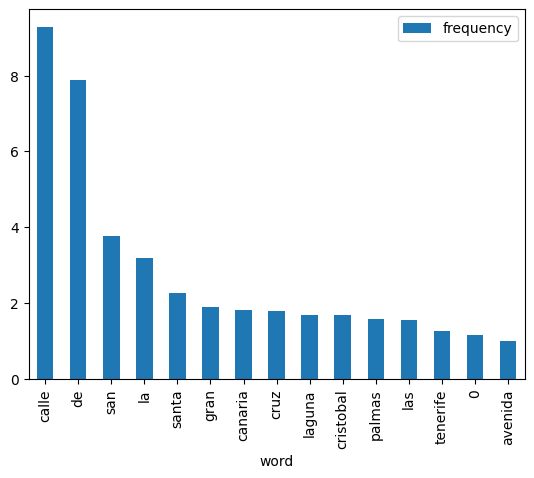

In [67]:
import matplotlib.pyplot
# Imprimir las 20 palabras más frecuentes
word_counter.toPandas().head(15).plot.bar(x = "word", y = "frequency")

## Distancia entre direcciones

#### Lectura del dataframe de validación

In [4]:
try:
  test_df = spark.read.format('parquet').load('../data/proccesed_data/test_dataframe2.parquet').repartition(32)
except:
  print('No se ha podido leer el dataset de testeo.')

# *TODO*:
- Hacer todo por lotes. Aplicar el crossjoin por lotes y realizar las evaluaciones
- Extraer muestras para realizar las evaluaciones
- Buscar la manera de extraer la informacion para usar Chromadb, es posible aplicar la realizacion por lotes
- Dos opciones: tener dos dataframes en chroma o tener uno pero añadir metadato para diferenciarlos.

## 10/04
- Limitar los datos a un municipio o isla para verlos resultados y comprobar que todo funciona (añadir como metadato el munipio y codigo postal)
- Comprobar cuanto destacan las distancias

### Distancia del coseno

In [5]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf

def accertion_ratio(dataframe):
  return dataframe.filter("evaluation == true").count() / dataframe.count()

def calculate_cosine_similarity(df1, df2):
  """ Realiza el cross join de dos dataframes """
  
  return df2.select("uuid_idt", "direccion", "embedding") \
    .withColumnRenamed("uuid_idt", "uuid_idt2") \
    .withColumnRenamed("direccion", "direccion2") \
    .withColumnRenamed("embedding", "embedding2") \
    .crossJoin(df1) \
    .repartition(32) \
    .withColumn("cosine_similarity", cosine_similarity("embedding", "embedding2"))
  
def filter_3_best(dataset):
  # Definimos la ventana de partición por uuid_idt y ordenamos por la columna cosine_similarity en orden descendente
  windowSpec = Window.partitionBy("uuid_idt").orderBy(col("cosine_similarity").desc())

  cosine_similarity_df = dataset.withColumn("rank", row_number().over(windowSpec))

  top3_cosine_similarity_df = cosine_similarity_df.filter(col("rank") <= 3)
  # top3_cosine_similarity_df.select("uuid_idt2", "direccion2", "uuid_idt", "direccion", "rank").show()
  return top3_cosine_similarity_df.drop("rank")

@udf(returnType=FloatType())
def cosine_similarity(embedding_dir1, dirembedding_dir2):
    return float(embedding_dir1.dot(dirembedding_dir2) / (embedding_dir1.norm(2) * dirembedding_dir2.norm(2)))

# Registrar la función UDF en Spark
spark.udf.register("cosine_similarity", cosine_similarity)

""" from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from functools import reduce

# Función para calcular la similitud del coseno
@udf(returnType=FloatType())
def cosine_similarity(embedding_dir1, dirembedding_dir2):
    return float(embedding_dir1.dot(dirembedding_dir2) / (embedding_dir1.norm(2) * dirembedding_dir2.norm(2)))

# Registrar la función UDF en Spark
spark.udf.register("cosine_similarity", cosine_similarity)

# Función para calcular la similitud del coseno en lotes
def calculate_cosine_similarity_in_batches(df1, df2, batch_size=1000):
    
    df2 = df2.select("uuid_idt", "direccion", "embedding") \
      .withColumnRenamed("uuid_idt", "uuid_idt2") \
      .withColumnRenamed("direccion", "direccion2") \
      .withColumnRenamed("embedding", "embedding2") \
    # Obtener el número total de filas en df2
    total_rows = df2.count()
    # Calcular el número total de lotes
    num_batches = total_rows // batch_size + (1 if total_rows % batch_size > 0 else 0)
    
    # Lista para almacenar los resultados
    results = []
    
    # Procesar en lotes
    for i in range(num_batches):
        # Obtener el rango de filas para el lote actual
        start_row = i * batch_size
        end_row = min((i + 1) * batch_size, total_rows)
        
        # Obtener el lote del DataFrame df2
        batch_df2 = df2.limit(end_row).subtract(df2.limit(start_row))
        
        # Realizar el join entre los lotes
        joined_df = batch_df2.crossJoin(df1)
        
        # Calcular la similitud del coseno en el lote actual
        batch_results = joined_df.withColumn("cosine_similarity", cosine_similarity("embedding2", "embedding"))
        
        # Agregar los resultados del lote a la lista
        results.append(batch_results)
    
    # Combinar los resultados de los lotes en un solo DataFrame
    return reduce(lambda df1, df2: df1.union(df2), results)

# Función para filtrar los 3 mejores resultados
def filter_3_best(dataset):
    # Definir la ventana de partición por uuid_idt y ordenar por la columna cosine_similarity en orden descendente
    windowSpec = Window.partitionBy("uuid_idt").orderBy(col("cosine_similarity").desc())

    # Agregar una columna "rank" que contiene el número de fila para cada partición
    cosine_similarity_df = dataset.withColumn("rank", row_number().over(windowSpec))

    # Filtrar para mantener solo los 3 mejores resultados para cada uuid_idt
    top3_cosine_similarity_df = cosine_similarity_df.filter(col("rank") <= 3)

    # Eliminar la columna "rank" ya que ya no la necesitamos
    return top3_cosine_similarity_df.drop("rank")

# Función para calcular la proporción de aceptación
def accertion_ratio(dataframe):
    return dataframe.filter("evaluation == true").count() / dataframe.count() 
    
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="direccion", outputCol="words")
w2v_cosine = tokenizer.transform(test_dataframe)
w2v_cosine = w2v_model.transform(w2v_cosine).select("uuid_idt", "direccion", "embedding")

# Realizar el cálculo de la similitud del coseno en lotes
cosine_similarity_df = calculate_cosine_similarity_in_batches(w2v_cosine, word2vec_result)

# Filtrar los 3 mejores resultados
top3_cosine_similarity_df = filter_3_best(cosine_similarity_df)

# Calcular la proporción de aceptación
acceptance_ratio = accertion_ratio(top3_cosine_similarity_df)

# Mostrar resultados o hacer lo que necesites con ellos
top3_cosine_similarity_df.show()    
"""


' from pyspark.sql.window import Window\nfrom pyspark.sql.functions import row_number, col\nfrom pyspark.sql.types import FloatType\nfrom pyspark.sql.functions import udf\nfrom functools import reduce\n\n# Función para calcular la similitud del coseno\n@udf(returnType=FloatType())\ndef cosine_similarity(embedding_dir1, dirembedding_dir2):\n    return float(embedding_dir1.dot(dirembedding_dir2) / (embedding_dir1.norm(2) * dirembedding_dir2.norm(2)))\n\n# Registrar la función UDF en Spark\nspark.udf.register("cosine_similarity", cosine_similarity)\n\n# Función para calcular la similitud del coseno en lotes\ndef calculate_cosine_similarity_in_batches(df1, df2, batch_size=1000):\n    \n    df2 = df2.select("uuid_idt", "direccion", "embedding")       .withColumnRenamed("uuid_idt", "uuid_idt2")       .withColumnRenamed("direccion", "direccion2")       .withColumnRenamed("embedding", "embedding2")     # Obtener el número total de filas en df2\n    total_rows = df2.count()\n    # Calcular el n

### Word2Vec

In [4]:
try:
  word2vec_result = spark.read.format('parquet').load('../data/proccesed_data/word2vec_result.parquet')
except:
  print('No se ha podido leer el dataset de testeo.')

In [27]:
word2vec_result.groupBy("nommun").count().orderBy('count', ascending=False).show(truncate=False)

24/04/24 15:21:31 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/24 15:21:45 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB


+--------------------------+------+
|nommun                    |count |
+--------------------------+------+
|San Cristóbal de La Laguna|129528|
|Las Palmas de Gran Canaria|117137|
|Santa Cruz de Tenerife    |97068 |
|Arona                     |64118 |
|Telde                     |49493 |
|San Bartolomé de Tirajana |40827 |
|La Orotava                |37390 |
|Adeje                     |35897 |
|Granadilla de Abona       |29390 |
|Arrecife                  |27999 |
|Santa Lucía de Tirajana   |25174 |
|Puerto del Rosario        |24664 |
|Los Realejos              |22031 |
|Icod de los Vinos         |21083 |
|La Oliva                  |21061 |
|Arucas                    |20798 |
|Pájara                    |18933 |
|Puerto de la Cruz         |18794 |
|San Miguel de Abona       |18465 |
|Candelaria                |18022 |
+--------------------------+------+
only showing top 20 rows



In [28]:
w2v_model = model_word2vec

In [6]:
from pyspark.ml.feature import Word2VecModel

w2v_model = Word2VecModel.load("../models/word2vec_model")

In [29]:
# Filter
word2vec_result = word2vec_result.filter("nommun == 'San Cristóbal de La Laguna'")

In [30]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="direccion", outputCol="words")
w2v_cosine = tokenizer.transform(test_df)

# Filter
w2v_cosine = w2v_cosine.filter("nommun == 'San Cristóbal de La Laguna'") 

w2v_cosine = w2v_model.transform(w2v_cosine).select("uuid_idt", "direccion", "embedding")

In [9]:
print(word2vec_result.count())
print(w2v_cosine.count())

170143
83001


In [31]:
""" 
word2vec_result: 1.779.568
w2v_cosine: 451.876
crossjoin result: 804.144.069.568 (df1 x df2) 
"""

evaluated_word2vec_cosine = calculate_cosine_similarity(word2vec_result, w2v_cosine)
# evaluated_word2vec_cosine.sort(asc("uuid_idt2")).show()
evaluated_word2vec_cosine = filter_3_best(evaluated_word2vec_cosine)
# evaluated_word2vec_cosine.sort(asc("uuid_idt2")).show()
# evaluated_word2vec_cosine.groupBy("uuid_idt").count().show()
evaluated_word2vec_cosine = evaluated_word2vec_cosine.repartition(32)
evaluated_word2vec_cosine = evaluated_word2vec_cosine.withColumn("evaluation", evaluated_word2vec_cosine.uuid_idt == evaluated_word2vec_cosine.uuid_idt2)

# from pyspark.sql.functions import desc, asc
# evaluated_word2vec_cosine.sort(asc("uuid_idt2")).show()

#### Evaluación

In [32]:
evaluated_word2vec_cosine.filter("evaluation == 'True'").count()

5

In [ ]:
evaluated_word2vec_cosine.select("uuid_idt").count()

In [13]:
word2vec_result.limit(10).show()

+--------------------+-----------+--------------------+-----+------+--------------------+--------------------+--------------------+--------------------+
|            uuid_idt|       tvia|                nvia|numer|codmun|              nommun|           direccion|               words|           embedding|
+--------------------+-----------+--------------------+-----+------+--------------------+--------------------+--------------------+--------------------+
|01987842-FBE4-460...|     PARAJE|            HERCULES|   10| 38023|San Cristóbal de ...|PARAJE HERCLUES 1...|[paraje, herclues...|[0.04731898475438...|
|030CD241-C682-411...|EXTRARRADIO|LUNA LLENA TRANSV...|    9| 38023|San Cristóbal de ...|EXTRARRADIO LUNA ...|[extrarradio, lun...|[-0.0215288131342...|
|039FAD75-7525-11E...|      VALLE|       CAMINO CAÑADA|  109| 38023|San Cristóbal de ...|VALLE CAMINO CAÑA...|[valle, camino, c...|[0.06081359729998...|
|03A2B8C4-7525-11E...|    ENTRADA|PUNTA HIDALGO BAJ...|    0| 38023|San Cristóbal 

In [20]:
evaluated_word2vec_cosine.show(truncate=False)

+------------------------------------+-----------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [25]:
evaluated_word2vec_cosine.select("uuid_idt", "uuid_idt2", "direccion", "direccion2", "cosine_similarity").show(truncate=False)

+------------------------------------+------------------------------------+-------------------------------------------------------------------------------+-----------------------------------------------------------------------+-----------------+
|uuid_idt                            |uuid_idt2                           |direccion                                                                      |direccion2                                                             |cosine_similarity|
+------------------------------------+------------------------------------+-------------------------------------------------------------------------------+-----------------------------------------------------------------------+-----------------+
|05DF4E46-4F82-450B-ACF3-E2757D0AE09B|7438477F-3251-11E8-9F08-480FCF5217B3|ANGOSTA CARTA 10 SAN CRISTOBAL DE LA LAGUAN                                    |CRA CANDILA LGAUNA 21 SAN CRISTOBAL DE LA LGAUNA                       |0.91462225       |
|33ECFF0C-9C99-4

In [ ]:
evaluated_word2vec_cosine.select("evaluation").filter("evaluation == true").count()
# 1.000 2min
# 10.000 error

In [ ]:
print(accertion_ratio(evaluated_word2vec_cosine))

In [ ]:
# !!! Error por falta de almacenamiento
evaluated_word2vec_cosine.write.format('parquet').save("../data/proccesed_data/word2vec_cosine.parquet")

#### Test

--------

In [12]:
# Obtener una lista de UUID únicos
uuids = [fila.uuid_idt for fila in w2v_cosine.select("uuid_idt").distinct().collect()]

df2 = word2vec_result.limit(10)
# batch_size = 1000
# total_rows = df2.count()

x = spark.createDataFrame([], "uuid_idt: string, uuid_idt2: string, direccion: string, direccion2: string, cosine_similarity: float, evaluation: boolean")

for uuid in uuids:
  df1 = w2v_cosine.filter(w2v_cosine.uuid_idt == uuid) # 5min: Ralentiza la ejecución porque tiene que filtar 257 mil veces
  # Procesar en lotes
  """ for i in range(0, total_rows, batch_size):
    # Obtener el rango de filas para el lote actual
    start_row = i
    end_row = min(i + batch_size, total_rows)
    
    # Obtener el lote del DataFrame df2
    batch_df2 = df2.limit(end_row).subtract(df2.limit(start_row)) """
    
  # joined_df = df2.crossJoin(df1) # 12min

  evaluated_word2vec_cosine = calculate_cosine_similarity(df1, df2)
  evaluated_word2vec_cosine = filter_3_best(evaluated_word2vec_cosine)
  evaluated_word2vec_cosine = evaluated_word2vec_cosine.withColumn("evaluation", evaluated_word2vec_cosine.uuid_idt == evaluated_word2vec_cosine.uuid_idt2)
  x.union(evaluated_word2vec_cosine.select("uuid_idt", "uuid_idt2", "direccion", "direccion2", "cosine_similarity", "evaluation"))
 
  # Calcular la similitud del coseno en el lote actual
  # batch_results = joined_df.withColumn("cosine_similarity", cosine_similarity("embedding2", "embedding"))

""" uuids = [row.uuid_idt for row in w2v_cosine.select("uuid_idt").distinct().collect()]

batches_size = 1000

df2 = word2vec_result
total_rows = df2.count()

for uuid in uuids:
  df1 = w2v_cosine.filter(w2v_cosine.uuid_idt == uuid)
  for i in range(batches_size):
    # Obtener el rango de filas para el lote actual
    start_row = i * batches_size
    end_row = min((i + 1) * batches_size, total_rows)
    
    # Obtener el lote del DataFrame df2
    batch_df2 = df2.limit(end_row).subtract(df2.limit(start_row))
    
    # Realizar el join entre los lotes
    joined_df = batch_df2.crossJoin(df1)
    
    # Calcular la similitud del coseno en el lote actual
    batch_results = joined_df.withColumn("cosine_similarity", cosine_similarity("embedding2", "embedding")) """
      

ERROR:root:KeyboardInterrupt while sending command.                             
Traceback (most recent call last):
  File "/home/usuario/Address-matching/env_address_matching/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/usuario/Address-matching/env_address_matching/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [7]:
word2vec_result.show(5)

+--------------------+---------+--------------------+-----+------+--------------------+--------------------+--------------------+--------------------+
|            uuid_idt|     tvia|                nvia|numer|codmun|              nommun|           direccion|               words|           embedding|
+--------------------+---------+--------------------+-----+------+--------------------+--------------------+--------------------+--------------------+
|0016535F-03E9-429...|VIVIENDAS|SIROCO CUEVAS BLA...|   21| 38038|Santa Cruz de Ten...|VIVIENDAS SIROCO ...|[viviendas, siroc...|[-0.1428224661697...|
|00760F34-E924-418...|  BLOQUES|BRISAMAR III CL A...|    8| 38038|Santa Cruz de Ten...|BLOQUES BRISAMAR ...|[bloques, brisama...|[-0.1585414991714...|
|00AB4743-6F76-427...|  ANGOSTA|         CAMINO TRES|   83| 38008|          Breña Alta|ANGOSTA CAMINO TR...|[angosta, camino,...|[-0.0305986578265...|
|00EE8A38-3881-449...|    VALLE|              MEXICO|   42| 35034|               Yaiza|AVLLE M

### MiniLM

In [30]:
from sentence_transformers import SentenceTransformer
from pyspark.sql.types import ArrayType, FloatType

minilm_model = SentenceTransformer("all-MiniLM-L6-v2")

def minilm_embedding(direccion):
    """ Calcula el embedding de la direccion dada y lo convierte a una lista para evitar la serelización de Spark """
    embedding = minilm_model.encode(direccion)
    return embedding.tolist()

@udf(returnType=ArrayType(FloatType()))
def minilm_embedding_udf(direccion):
    return minilm_embedding(direccion)

minilm_cosine = test_df.withColumn("embedding", minilm_embedding_udf("direccion"))

In [31]:
minilm_cosine = minilm_cosine.filter("nommun == 'San Cristóbal de La Laguna'") 
# Filter
minilm_result = minilm_result.filter("nommun == 'San Cristóbal de La Laguna'")

In [ ]:
evaluated_minilm_cosine = calculate_cosine_similarity(minilm_cosine, minilm_result)
evaluated_minilm_cosine = filter_3_best(evaluated_minilm_cosine)
evaluated_minilm_cosine = evaluated_minilm_cosine.withColumn("evaluation", evaluated_minilm_cosine.uuid_idt == evaluated_minilm_cosine.uuid_idt2)

In [ ]:
print(accertion_ratio(evaluated_minilm_cosine))

### GPT

In [6]:
from pyspark.sql.types import ArrayType, FloatType
from pyspark.sql.functions import udf
from openai import OpenAI

def get_embedding(text, model="text-embedding-3-small"):
    client = OpenAI(api_key="***REMOVED***")
    text = text.replace("\n", " ")
    return client.embeddings.create(input=[text], model=model).data[0].embedding

# Definir la función UDF y especificar el tipo de dato de retorno como ArrayType(FloatType())
embedding_udf = udf(lambda text: get_embedding(text), ArrayType(FloatType()))

# Aplicar la función UDF al DataFrame y crear una nueva columna llamada embeddings"
gpt3_cosine = test_df.withColumn("embedding", embedding_udf("direccion"))

In [7]:
gpt3_cosine = gpt3_cosine.filter("nommun == 'San Cristóbal de La Laguna'")
gpt3_result = gpt3_result.filter("nommun == 'San Cristóbal de La Laguna'")

In [14]:
evaluated_gpt3_cosine = calculate_cosine_similarity(gpt3_cosine, gpt3_result)
evaluated_gpt3_cosine = filter_3_best(evaluated_gpt3_cosine)
evaluated_gpt3_cosine = evaluated_gpt3_cosine.withColumn("evaluation", evaluated_gpt3_cosine.uuid_idt == evaluated_gpt3_cosine.uuid_idt2)

In [ ]:
evaluated_gpt3_cosine.filter("evaluation == 'True'").count()

In [ ]:
print(accertion_ratio(evaluated_gpt3_cosine))

### Chroma DB

#### Connect

In [32]:
import chromadb

# Conéctate al cliente de ChromaDB y crea la colección
chroma_client = chromadb.Client()
collection = chroma_client.create_collection(name="address_matching")

In [34]:
from pyspark.ml.linalg import DenseVector

def extract_to_chroma(dataframes):
    embeddings = []
    documents = []
    metadata = []
    ids = []
    start = 0
    
    for index in range(len(dataframes)):
        type_df = "test" if index == 1 else "train" 
        
        # Extraer los datos restantes como listas
        embeddings_df = dataframes[index].select("embedding").collect()
        documents_df = dataframes[index].select("direccion").collect()
        metadata_df = dataframes[index].select("uuid_idt").collect()
        ids_df = list(range(start, len(embeddings_df) + start))

        # print(type(embeddings_df[0].embedding))
        # Extraer los embeddings como listas
        embeddings_list = []
        for row in embeddings_df:
            if type(row.embedding) != list:
                embeddings_list.append(row.embedding.toArray().tolist())
            else:
                embeddings_list.append(row.embedding)
        embeddings_df = embeddings_list
        # embeddings_df = [row.embedding.toArray().tolist() for row in embeddings_df]

        # Extraer los documentos como listas
        documents_df = [row.direccion for row in documents_df]

        # Extraer los metadatos como listas
        metadata_df = [{"uuid_idt": row.uuid_idt, "type_df": type_df} for row in metadata_df]
        
        ids_df = [str(id_) for id_ in ids_df]

        embeddings += embeddings_df
        documents += documents_df
        metadata += metadata_df
        ids += ids_df
        start = len(ids_df)

    return ids, documents, embeddings, metadata

def extract_to_chroma1(dataframe, type_df):
    ids = []
    documents = []
    embeddings = []
    metadata = []

    # Recopilar los datos del DataFrame
    rows = dataframe.select("uuid_idt", "latitud", "longitud", "direccion", "embedding").collect()
    index = 0
    for row in rows:
        # Extraer los datos de cada fila
        uuid_idt = str(row.uuid_idt)
        direccion = str(row.direccion)
        embedding = row.embedding.toArray().tolist() if isinstance(row.embedding, DenseVector) else row.embedding

        # Agregar los datos a las listas correspondientes
        ids.append(str(index))
        documents.append(direccion)
        embeddings.append(embedding)
        metadata.append({
            "uuid_idt": uuid_idt, 
            "latitud": float(row.latitud),
            "longitud": float(row.longitud),
            "type_df": type_df
            })
        index += 1
    return embeddings, documents, metadata, ids 


def chunk_data(data, chunk_size):
    for i in range(0, len(data), chunk_size):
        yield data[i:i + chunk_size]

In [ ]:
schema = "uuid_idt_test: string, \
          latitud_test: float, \
          longitud_test: float, \
          direccion_test: string, \
          uuid_idt_train: string, \
          latitud_train: float, \
          longitud_train: float, \
          direccion_train: string"

In [78]:
def extract_data(test_result_collection, train_result_collection, dataframe):
  uuid_test_result = test_result_collection["metadatas"][0]["uuid_idt"]
  latitud_test_result = test_result_collection["metadatas"][0]["latitud"]
  longitud_test_result = test_result_collection["metadatas"][0]["longitud"]
  direccion_test_result = test_result_collection["documents"][0]
  test_data = (uuid_test_result, latitud_test_result, longitud_test_result, direccion_test_result)
  
  train_data = []
  for index in range(len(train_result_collection["ids"][0])):
    metadata = train_result_collection["metadatas"][0]
    uuid_train_result = metadata[index]["uuid_idt"]
    latitud_train_result = metadata[index]["latitud"]
    longitud_train_result = metadata[index]["longitud"]
    direccion_train_result = train_result_collection["documents"][0][index]
    
    train_data.append((uuid_train_result, latitud_train_result, longitud_train_result, direccion_train_result))

  for result in train_data:
    temp_df = spark.createDataFrame([test_data + result], schema)
    dataframe = dataframe.union(temp_df)
  return dataframe

""" def extract_data(test_result_collection, train_result_collection):
  global evaluated_no_match_dirs
  uuid_test_result = test_result_collection["metadatas"][0]["uuid_idt"]
  latitud_test_result = test_result_collection["metadatas"][0]["latitud"]
  longitud_test_result = test_result_collection["metadatas"][0]["longitud"]
  direccion_test_result = test_result_collection["documents"][0]
  
  test_data = (uuid_test_result, latitud_test_result, longitud_test_result, direccion_test_result)
  
  train_data = []
  for index in range(len(train_result_collection["ids"][0])):
    metadata = train_result_collection["metadatas"][0]
    uuid_train_result = metadata[index]["uuid_idt"]
    latitud_train_result = metadata[index]["latitud"]
    longitud_train_result = metadata[index]["longitud"]
    direccion_train_result = train_result_collection["documents"][0][index]
    
    train_data.append((uuid_train_result, latitud_train_result, longitud_train_result, direccion_train_result))

  # Creación de DataFrame para cada dato de entrenamiento y unión con el DataFrame del conjunto de prueba
  df_rows = [(test_data + result) for result in train_data]
  df = spark.createDataFrame(df_rows, schema)
  
  # Uniones de DataFrames
  evaluated_no_match_dirs = evaluated_no_match_dirs.union(df) """

' def extract_data(test_result_collection, train_result_collection):\n  global evaluated_no_match_dirs\n  uuid_test_result = test_result_collection["metadatas"][0]["uuid_idt"]\n  latitud_test_result = test_result_collection["metadatas"][0]["latitud"]\n  longitud_test_result = test_result_collection["metadatas"][0]["longitud"]\n  direccion_test_result = test_result_collection["documents"][0]\n  \n  test_data = (uuid_test_result, latitud_test_result, longitud_test_result, direccion_test_result)\n  \n  train_data = []\n  for index in range(len(train_result_collection["ids"][0])):\n    metadata = train_result_collection["metadatas"][0]\n    uuid_train_result = metadata[index]["uuid_idt"]\n    latitud_train_result = metadata[index]["latitud"]\n    longitud_train_result = metadata[index]["longitud"]\n    direccion_train_result = train_result_collection["documents"][0][index]\n    \n    train_data.append((uuid_train_result, latitud_train_result, longitud_train_result, direccion_train_result))

In [60]:
def evaluation(collection_test, collection_train, max_id):
  evaluated_dirs = spark.createDataFrame([], schema)
  
  counter = 0
  match = 0
  no_match = 0

  while counter < max_id:
    # Select from test df
    result = collection_test.get(
      ids=[str(counter)],
      include=["embeddings", "metadatas", "documents"]
    )

    # print(result)
    # print(result["embeddings"][0])
    # print(result["metadatas"][0]["uuid_idt"])
    
    # Embedding and uuid from test df
    embedding_to_evaluate = result["embeddings"][0]
    uuid_to_evaluate = result["metadatas"][0]["uuid_idt"]

    # Generate best similarities
    results_similarities = collection_train.query(
      query_embeddings=[embedding_to_evaluate],
      n_results=3
    )

    best_uuids = [u["uuid_idt"] for i in results_similarities["metadatas"] for u in i]
    # print(best_uuids)

    # print(result)
    # print("--------")
    # print(results_similarities, "\n")
    if uuid_to_evaluate in best_uuids:
      match+=1
    else:
      no_match+=1
      
    if match <= 100 and no_match <= 100:
      evaluated_dirs = extract_data(result, results_similarities, evaluated_dirs)
    counter+=1
  return match, no_match, evaluated_dirs

In [39]:
def add_to_collection(collection, embeddings_list, documents_list, metadata_list, ids_list):
  # Define el tamaño del lote
  batch_size = 41666

  # Divide tus datos en lotes más pequeños
  embeddings_chunks = list(chunk_data(embeddings_list, batch_size))
  documents_chunks = list(chunk_data(documents_list, batch_size))
  metadata_chunks = list(chunk_data(metadata_list, batch_size))
  ids_chunks = list(chunk_data(ids_list, batch_size))

  # Agrega cada lote por separado a la colección
  for embeddings, documents, metadata, ids in zip(embeddings_chunks, documents_chunks, metadata_chunks, ids_chunks):
      collection.add(embeddings=embeddings, documents=documents, metadatas=metadata, ids=ids)

#### Word2Vec

In [12]:
ids_list, documents_list, embeddings_list, metadata_list = extract_to_chroma1(w2v_cosine, "test")
collection_test_w2v = chroma_client.create_collection(name="test_df_w2v")
add_to_collection(collection_test_w2v, ids_list, documents_list, embeddings_list, metadata_list) # ?min

In [13]:
ids_list, documents_list, embeddings_list, metadata_list = extract_to_chroma1(word2vec_result, "train")
collection_train_w2v = chroma_client.create_collection(name="train_df_w2v")
add_to_collection(collection_train_w2v, ids_list, documents_list, embeddings_list, metadata_list) # 21min

In [29]:
match, no_match = evaluation(collection_test_w2v, collection_train_w2v, w2v_cosine.count() - 1)
print(match, no_match)

15841 67160


In [ ]:
""" max_id = w2v_cosine.count() + word2vec_result.count() - 1
counter = w2v_cosine.count()
yes = 0
no = 0
while counter < max_id:
  # Select from train df
  result = collection.get(
    ids=[str(counter)],
    include=["embeddings", "metadatas", "documents"]
  )

  # print(result)
  # print(result["embeddings"][0])
  # print(result["metadatas"][0]["uuid_idt"])
  
  # Embedding from train df
  e1 = result["embeddings"][0]
  u1 = result["metadatas"][0]["uuid_idt"]

  # Generate best similarities
  # TODO: filtrar antes por aquellos embeddings que son de "train"
  results_q = collection.query(
    query_embeddings=[e1],
    n_results=2,
  )

  uuids = [u["uuid_idt"] for i in results_q["metadatas"] for u in i]
  # print(uuids)

  if u1 in uuids:
    yes+=1
    print(result)
    print("--------")
    print(results_q)
  else:
    no+=1
  counter+=1

print(yes)
print(no) """

{'ids': [['90351', '33999', '130209', '91576', '140145']], 'distances': [[0.0, 0.19808949530124664, 0.20216217637062073, 0.20269343256950378, 0.22468826174736023]], 'metadatas': [[{'hnsw:space': 'cosine', 'type': 'test', 'uuid_idt': '6BD93CCB-3251-11E8-9BFD-480FCF5217B3'}, {'hnsw:space': 'cosine', 'type': 'train', 'uuid_idt': '683E27B8-3251-11E8-B413-480FCF5217B3'}, {'hnsw:space': 'cosine', 'type': 'test', 'uuid_idt': '6091C9B3-3251-11E8-BB6A-480FCF5217B3'}, {'hnsw:space': 'cosine', 'type': 'test', 'uuid_idt': '737D7422-1C73-476A-815F-292B1C2C11DD'}, {'hnsw:space': 'cosine', 'type': 'test', 'uuid_idt': '6273B1E0-3251-11E8-A556-480FCF5217B3'}]], 'embeddings': None, 'documents': [['CAMIN BOQUERON VALEL GUERRA 189 SAN CRISTOBAL DE LA LAGUNA', 'CG CARRETERA BOQUERON VALEL GUERRA 29 SAN CRISTOBAL DE LA LAGUNA', 'EXTRARRADIO VINO AVLLE GUERRA 357 SAN CRISTOBAL DE LA LAGUNA', 'DEIF BOQUERON VALLE GUERRA 85 SAN CRISTOBAL DE LA LAGUNA', 'CALLE BOQUERON VALLE GUERRA 214 SAN CRISTOBAL DE LA LAGUN

' # print(uuids)\nif u1 in uuids:\n  yes+=1\n  print(result)\n  print("--------")\n  print(results_q)\nelse:\n  no+=1\ncounter+=1\n\nprint(yes)\nprint(no) '

In [ ]:
from pyspark.sql.functions import col

# Función para procesar cada ID en paralelo
def process_id(id):
    result = collection.get(
        ids=[str(id)],
        include=["embeddings", "metadatas", "documents"]
    )
    e1 = result["embeddings"][0]
    u1 = result["metadatas"][0]["uuid_idt"]

    # Generar mejores similitudes en el conjunto de datos de entrenamiento
    results_q = collection.query(
        query_embeddings=[e1],
        n_results=2,
        where={"type": "train"}
    )
    uuids = [u["uuid_idt"] for i in results_q["metadatas"] for u in i]
    return u1 in uuids

# Crear un rango de IDs para procesar
max_id = w2v_cosine.count() - 1
ids_range = range(max_id)

# Convertir el rango de IDs en un DataFrame de Spark
ids_df = spark.createDataFrame(ids_range, "id")

# Aplicar la función de procesamiento a cada ID en paralelo utilizando Spark
results_df = ids_df.select("id").withColumn("match", process_id(col("id")))

# Contar los resultados positivos y negativos
yes_count = results_df.filter(results_df["match"] == True).count()
no_count = results_df.filter(results_df["match"] == False).count()

print("Yes count:", yes_count)
print("No count:", no_count)

#### GPT

In [ ]:
ids_list, documents_list, embeddings_list, metadata_list = extract_to_chroma([gpt3_cosine, gpt3_result])

In [18]:
ids_list, documents_list, embeddings_list, metadata_list = extract_to_chroma1(gpt3_cosine, "test")
collection_test_gpt = chroma_client.create_collection(name="test_df")
add_to_collection(collection_test_gpt, ids_list, documents_list, embeddings_list, metadata_list) # xmin

ERROR:root:KeyboardInterrupt while sending command.][Stage 6:>    (0 + 0) / 9]
Traceback (most recent call last):
  File "/home/usuario/Address-matching/env_address_matching/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/usuario/Address-matching/env_address_matching/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
ids_list, documents_list, embeddings_list, metadata_list = extract_to_chroma1(gpt3_result, "train")
collection_train_gpt = chroma_client.create_collection(name="train_df")
add_to_collection(collection_train_gpt, ids_list, documents_list, embeddings_list, metadata_list) # xmin

In [ ]:
match, no_match = evaluation(collection_test_gpt, collection_train_gpt, w2v_cosine.count() - 1)
print(match, no_match)

#### MiniLLM

In [37]:
print(minilm_result.count())
print(minilm_cosine.count())

24/04/27 08:54:13 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB


169772


24/04/27 08:54:40 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/27 08:55:05 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/04/27 08:55:13 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB


82891


In [59]:
chroma_client.delete_collection("test_df_minilm")
chroma_client.delete_collection("train_df_minilm")

In [ ]:
embeddings_list, documents_list, metadata_list, ids_list = extract_to_chroma1(minilm_cosine, "test")
collection_test_minilm = chroma_client.create_collection(name="test_df_minilm")
add_to_collection(collection_test_minilm, embeddings_list, documents_list, metadata_list, ids_list) # 10min

In [54]:
result = collection_test_minilm.get(
      ids=['0'],
      include=["metadatas", "documents"]
    )

print(result)
# minilm_cosine.filter("uuid_idt == '000C72C6-F85F-4FB3-81AA-407BAEAF922B'").show()

{'ids': ['0'], 'embeddings': None, 'metadatas': [{'latitud': 28.48819, 'longitud': -16.28094, 'type_df': 'test', 'uuid_idt': '000C72C6-F85F-4FB3-81AA-407BAEAF922B'}], 'documents': ['CALLE CABEZADA VALLE JIMENEZ 24 SAN CRISTOBAL DE LA LAGUNA'], 'uris': None, 'data': None}


In [41]:
embeddings_list, documents_list, metadata_list, ids_list = extract_to_chroma1(minilm_result, "train")
collection_train_minilm = chroma_client.create_collection(name="train_df_minilm")
add_to_collection(collection_train_minilm, embeddings_list, documents_list, metadata_list, ids_list) # 21min

24/04/27 09:29:06 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB


In [61]:
match, no_match, evaluated_dirs = evaluation(collection_test_minilm, collection_train_minilm, minilm_cosine.count() - 1)
print(match, no_match)

24/04/27 19:19:37 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/27 19:20:08 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/04/27 19:20:16 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB


37913 44972


In [62]:
evaluated_dirs.show(truncate=False)

24/04/27 19:23:57 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/04/27 19:23:58 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/04/27 19:23:58 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/04/27 19:23:59 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/04/27 19:24:04 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


+------------------------------------+------------+-------------+--------------------------------------------------------------+------------------------------------+-------------+--------------+--------------------------------------------------------------+
|uuid_idt_test                       |latitud_test|longitud_test|direccion_test                                                |uuid_idt_train                      |latitud_train|longitud_train|direccion_train                                               |
+------------------------------------+------------+-------------+--------------------------------------------------------------+------------------------------------+-------------+--------------+--------------------------------------------------------------+
|000C72C6-F85F-4FB3-81AA-407BAEAF922B|28.48819    |-16.28094    |CALLE CABEZADA VALLE JIMENEZ 24 SAN CRISTOBAL DE LA LAGUNA    |000C72C6-F85F-4FB3-81AA-407BAEAF922B|28.48819     |-16.28094     |CALLE CABEZADA VALLE JIMENEZ 24 

In [72]:
from pyspark.sql.functions import lit, col, udf
from haversine import haversine
from pyspark.sql.types import DoubleType

# Definir una función UDF (User Defined Function) para aplicar haversine
haversine_udf = udf(lambda lat1, lon1, lat2, lon2: haversine((lat1, lon1), (lat2, lon2)), returnType=DoubleType())

# Aplicar la función UDF a las columnas del DataFrame
evaluated_dirs = evaluated_dirs.withColumn("distance_haversine", 
                                           haversine_udf(col("latitud_test"), 
                                                         col("longitud_test"), 
                                                         col("latitud_train"), 
                                                         col("longitud_train")))
evaluated_dirs.write.csv("../data/proccesed_data/evaluated_dirs.csv")

In [ ]:
TODO: 
- probar con proporción 90 - 10
1. ver si las direcciones mal clasificadas están próximas a estar bien clasificadas. Agregar las coordenadas al df y en el caso de estar mal clasificadas, ver por cuanto fallan. Extraer 100 de cada caso (bien y mal clasificado)
- Usar 200 mil direcciones para calcular los embeddings usando la API de OpenAI dada
- Utilizar los uuid que tengan al menos 10 o mas direcciones asociadas

In [43]:
print(minilm_cosine.limit(10).select("uuid_idt", "latitud", "longitud", "direccion", "embedding").collect())

24/04/26 09:25:59 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/26 09:26:31 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/04/26 09:26:41 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB


[Row(uuid_idt='000C72C6-F85F-4FB3-81AA-407BAEAF922B', latitud='28.48819', longitud='-16.28094', direccion='CALLE CABEZADA VALLE JIMENEZ 24 SAN CRISTOBAL DE LA LAGUNA', embedding=[-0.02331388369202614, 0.0090729258954525, -0.02462688647210598, 0.047039005905389786, -0.10695862770080566, -0.0215102881193161, 0.02594497799873352, 0.059718310832977295, 0.030831480398774147, -0.020542122423648834, 0.03136146068572998, -0.11673516035079956, -0.009630272164940834, -0.04615824297070503, 0.002846973016858101, -0.004598279949277639, -0.011703044176101685, 0.0076271649450063705, 0.0823153555393219, -0.0241731908172369, 0.0261106975376606, -0.01573164388537407, -0.056988902390003204, 0.08307622373104095, -0.06887605786323547, -0.07290302217006683, -0.04966107755899429, 0.05127626657485962, -0.024711046367883682, -0.04055587947368622, 0.03987046331167221, 0.16633261740207672, 0.11824174225330353, -0.0017034183256328106, 0.007371372543275356, 0.09172456711530685, 0.020831171423196793, -0.06537034362